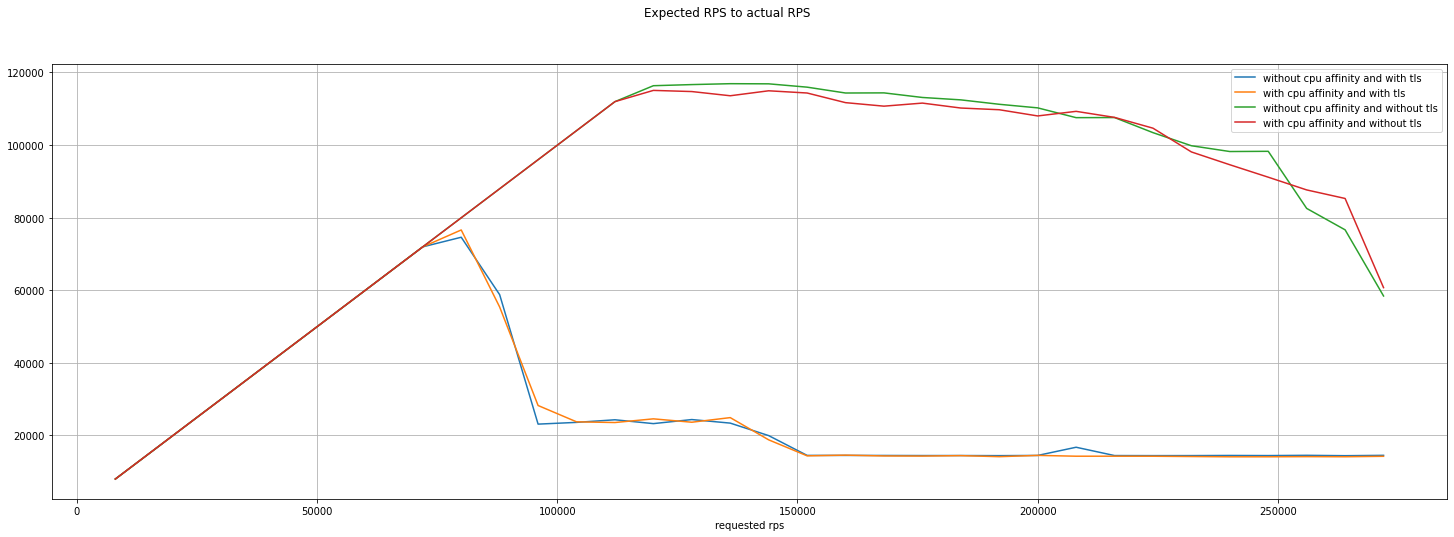

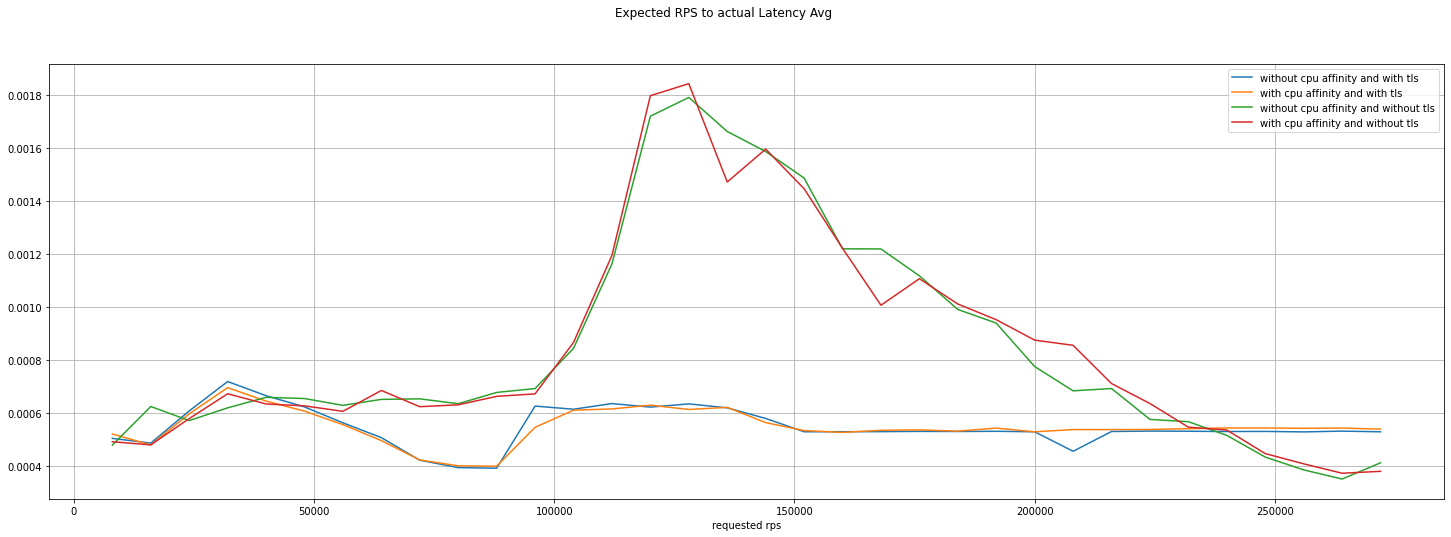

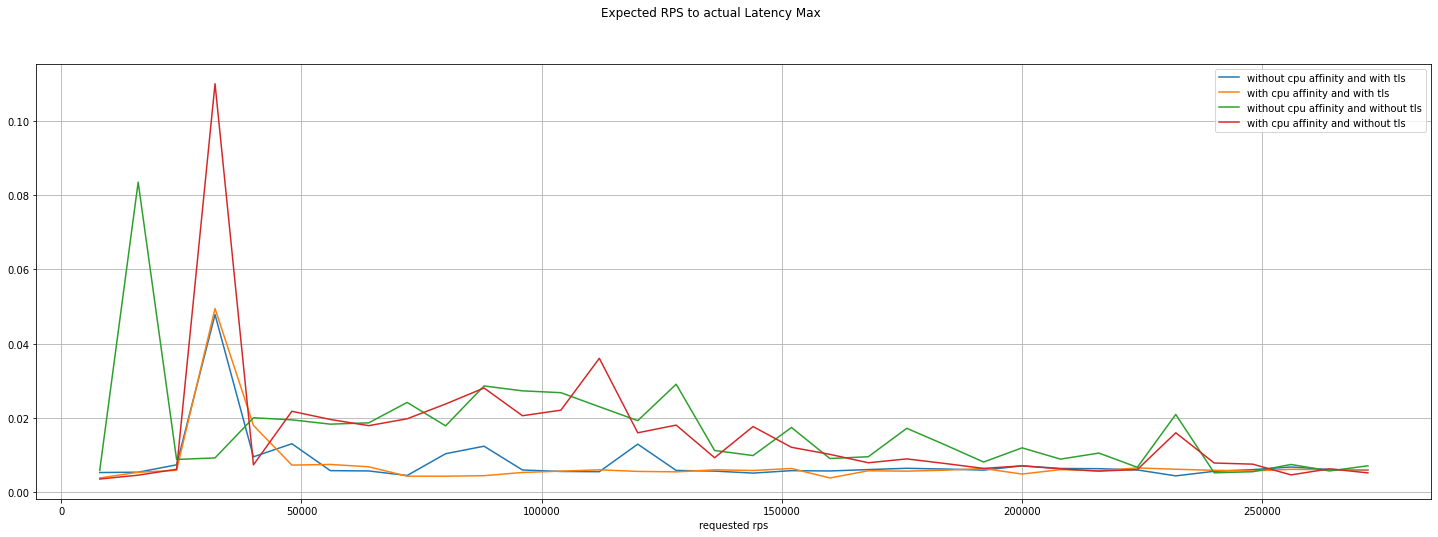

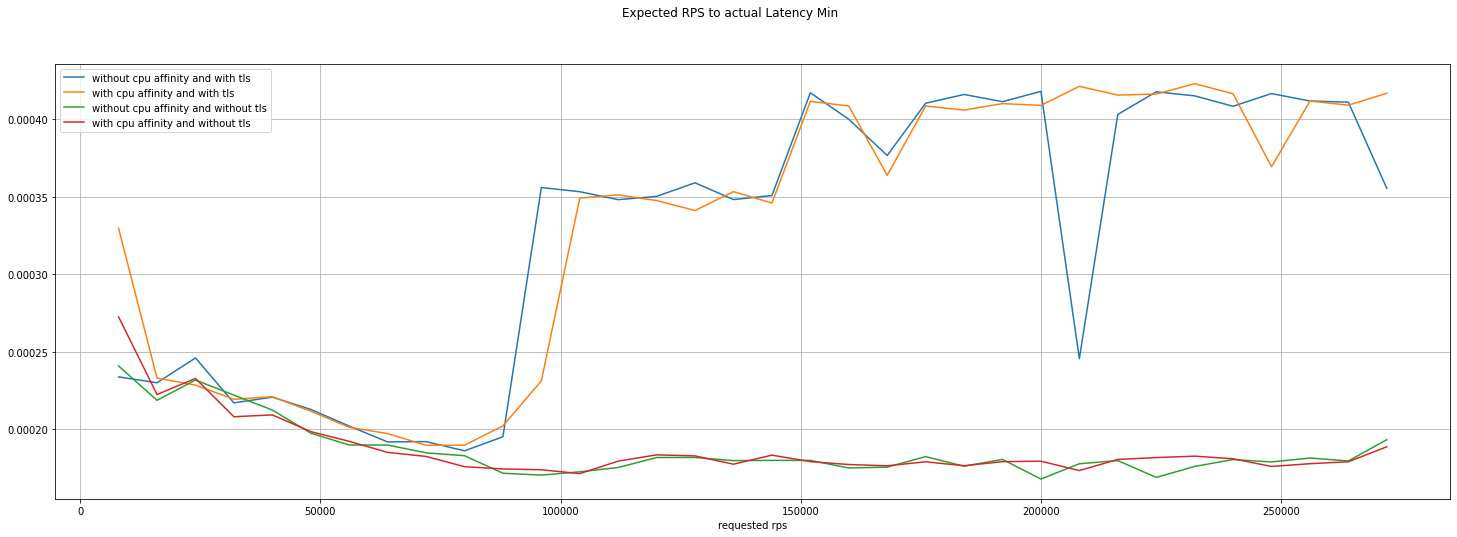

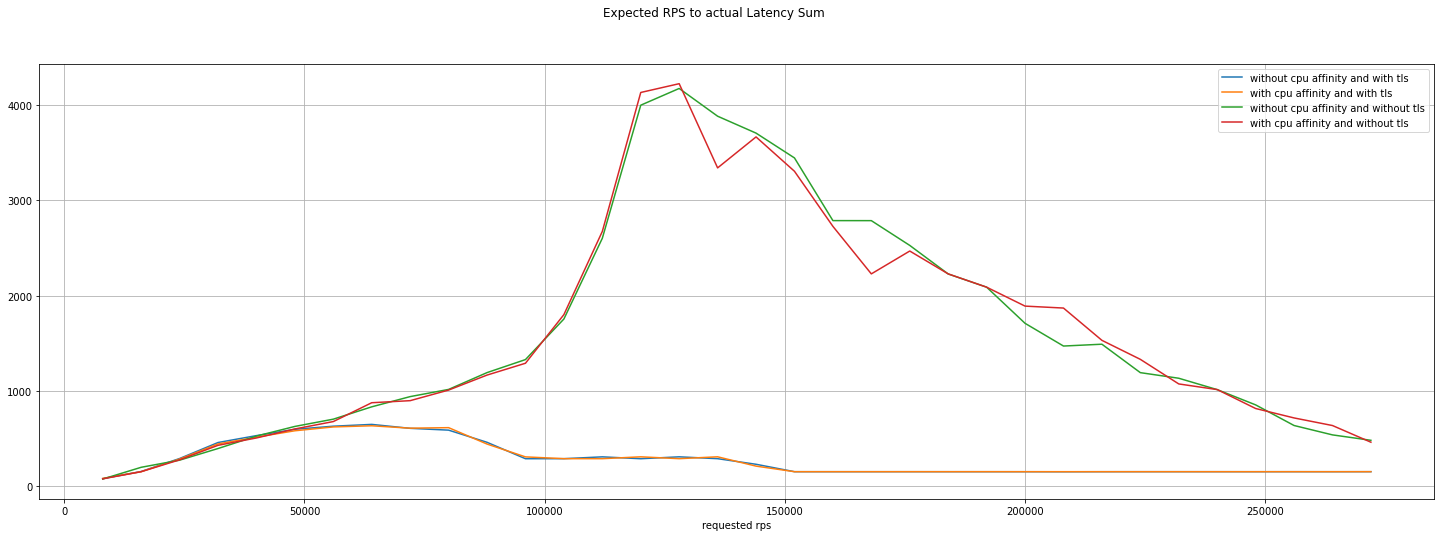

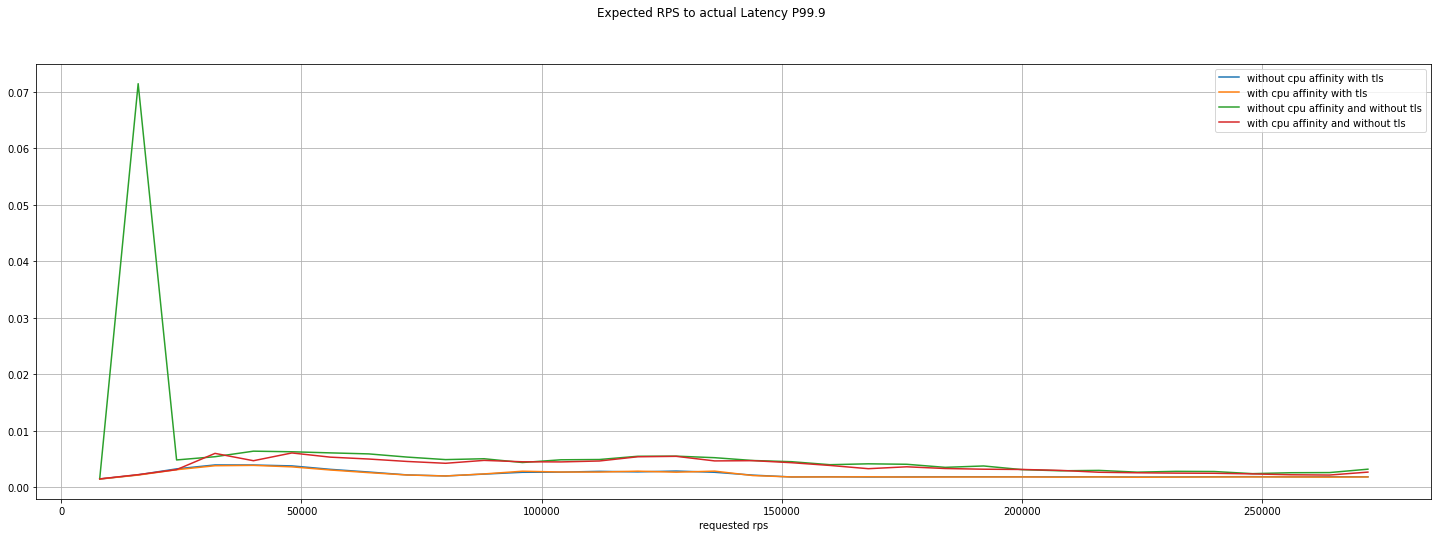

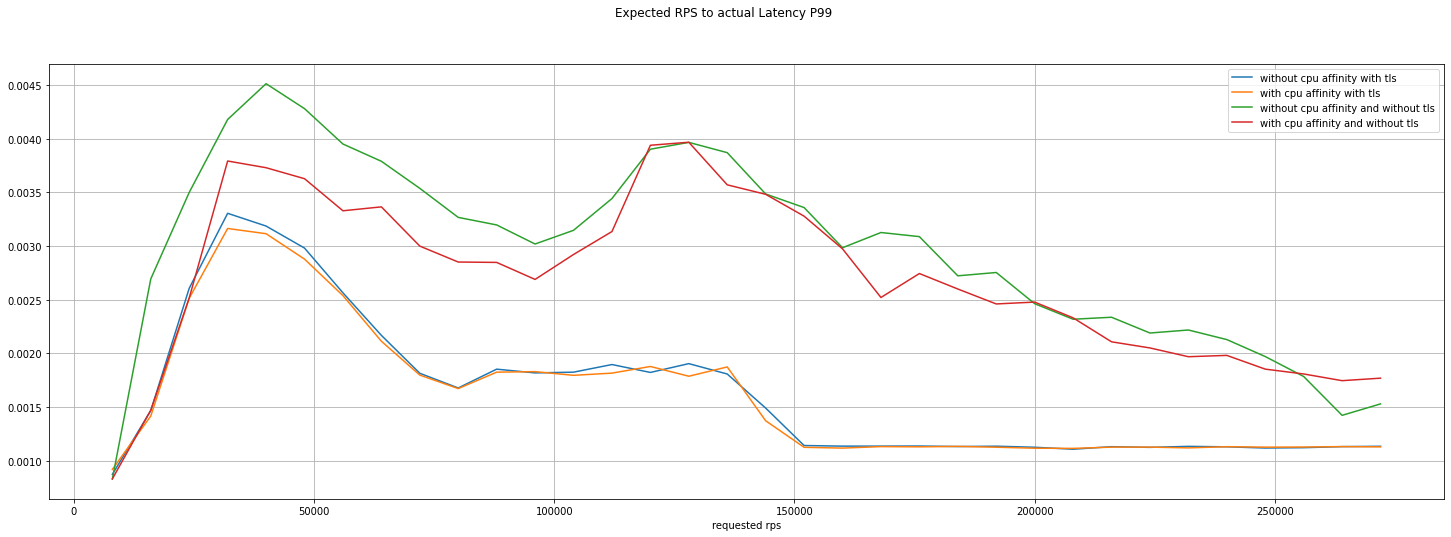

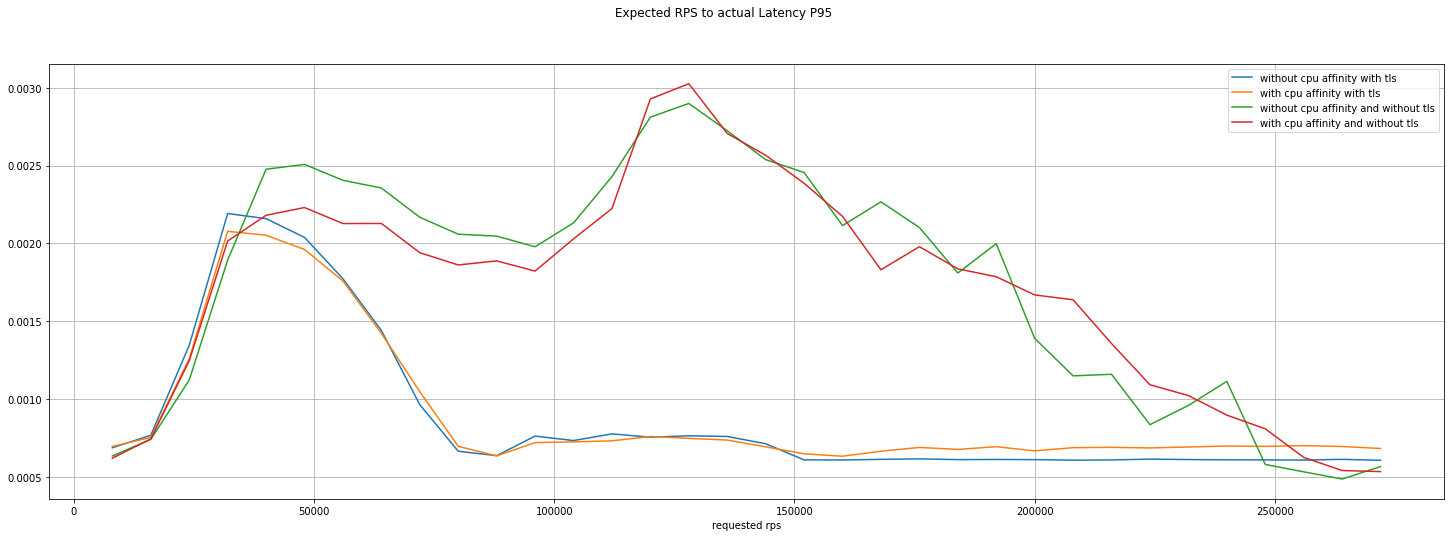

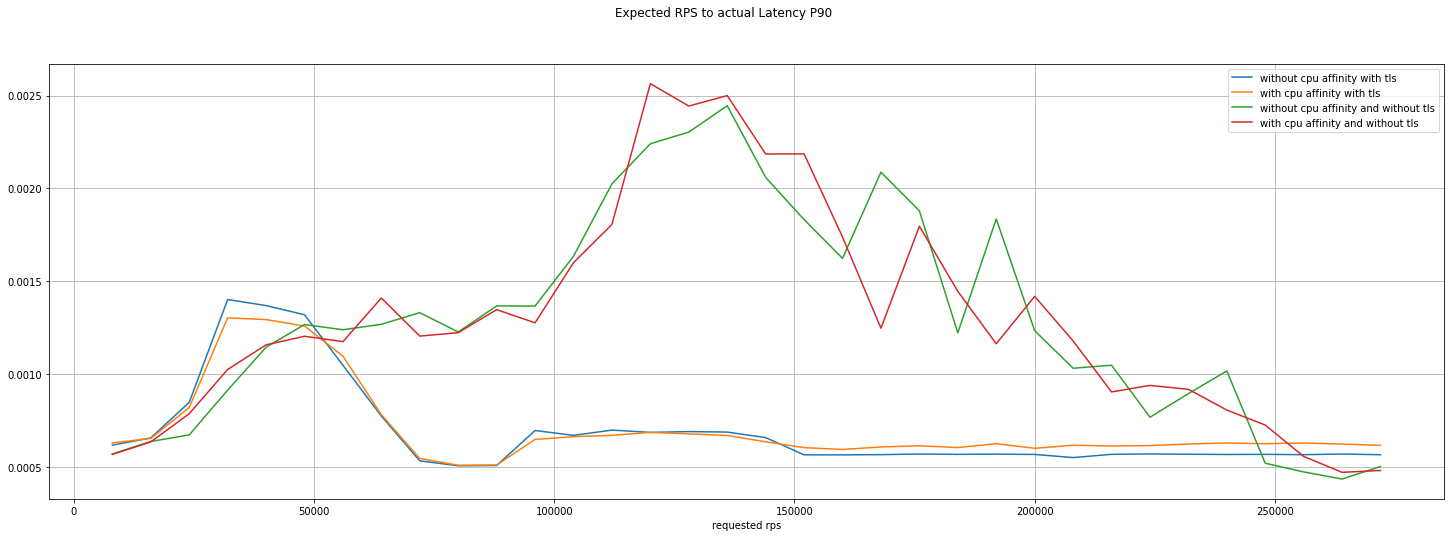

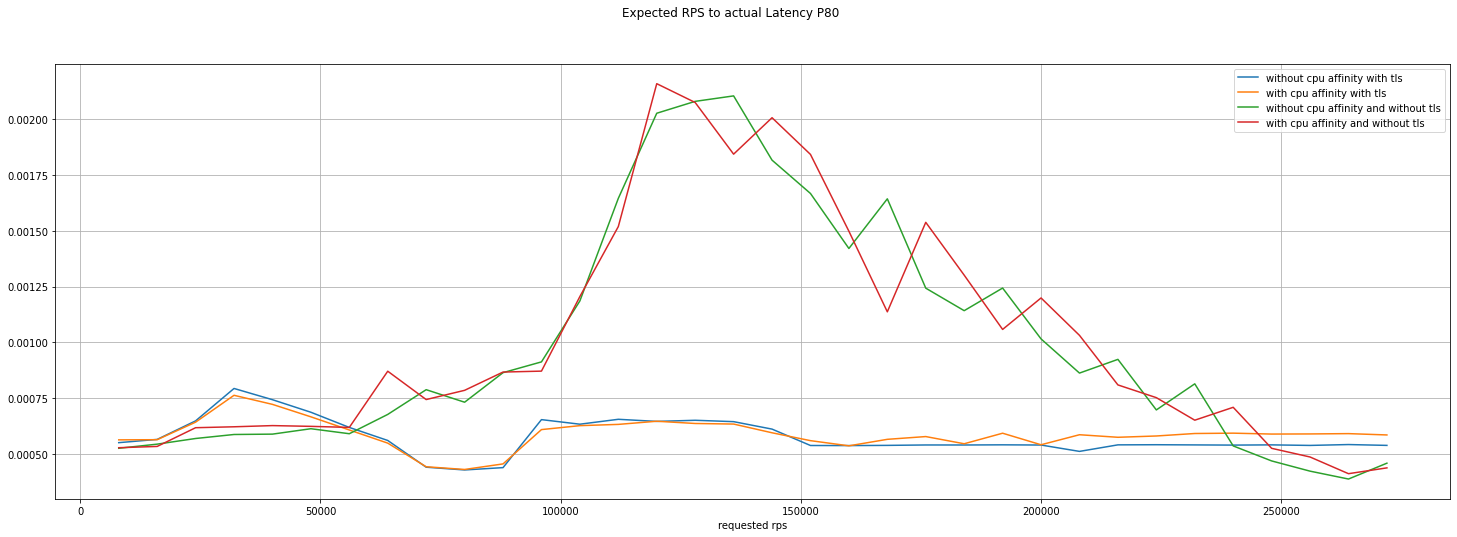

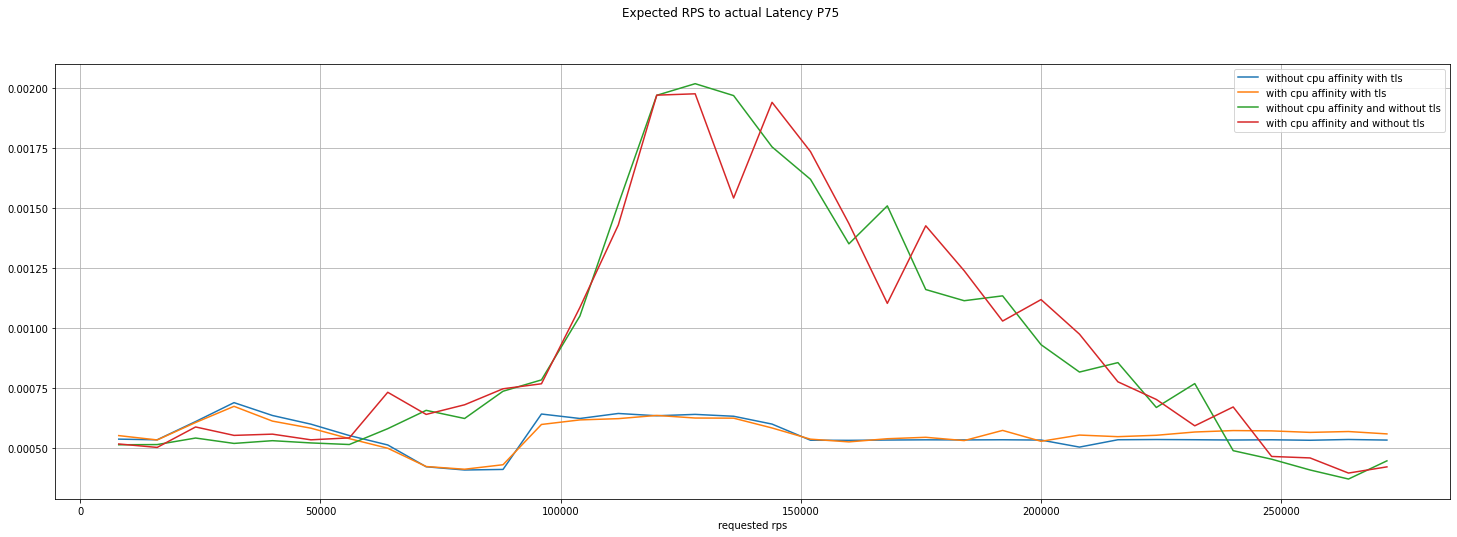

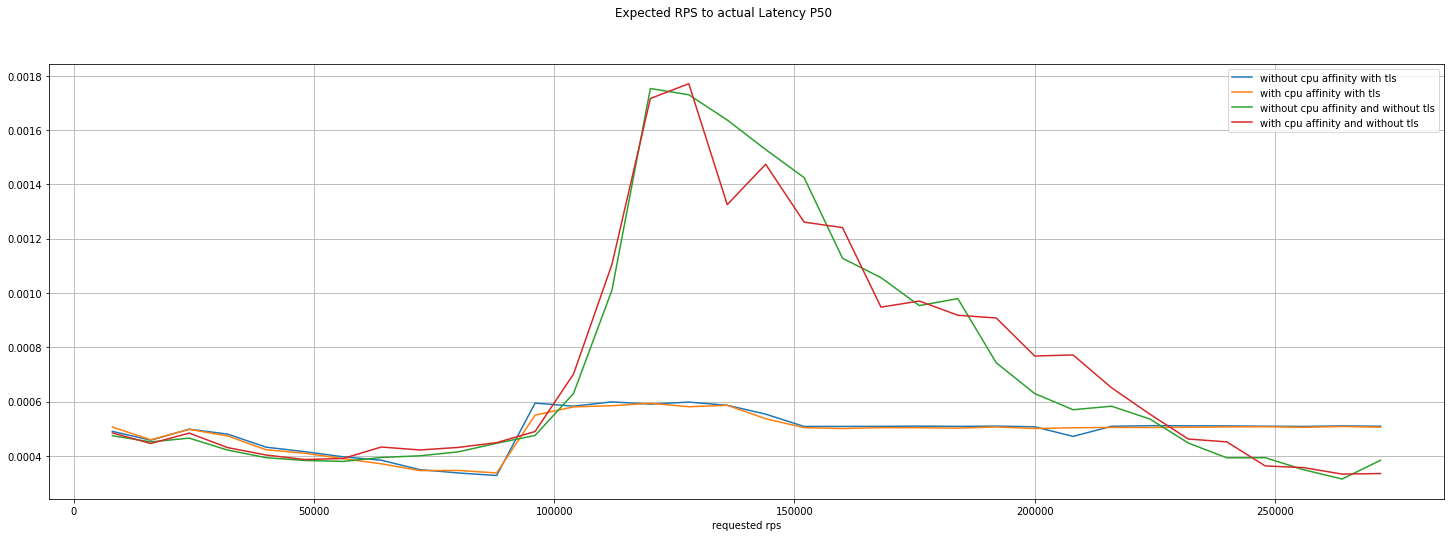

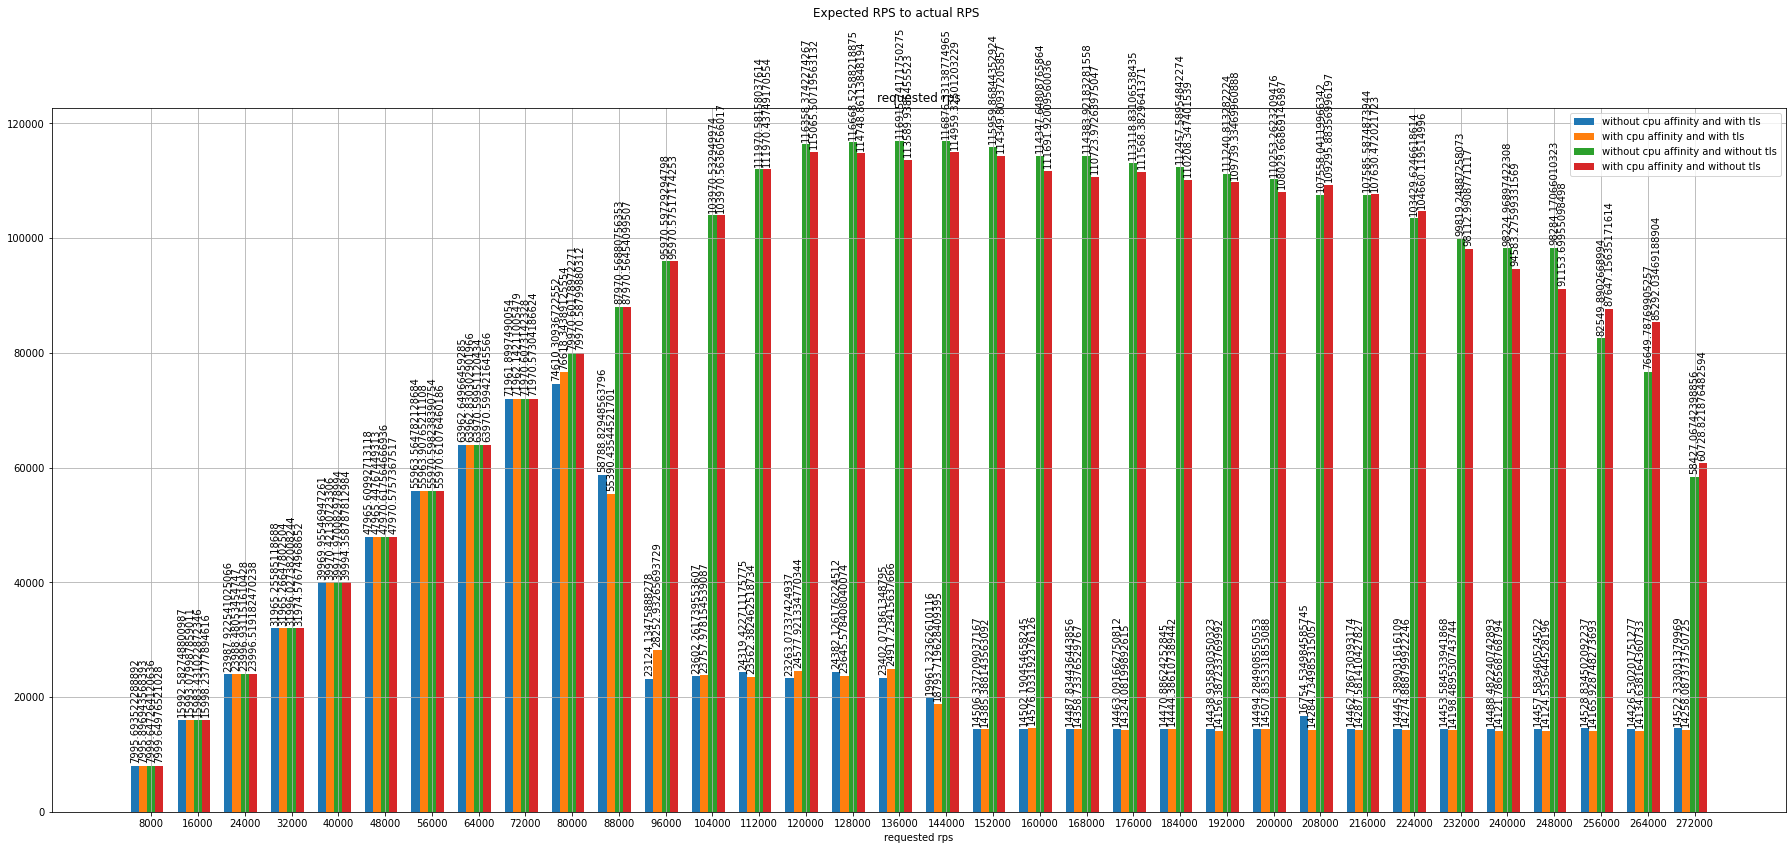

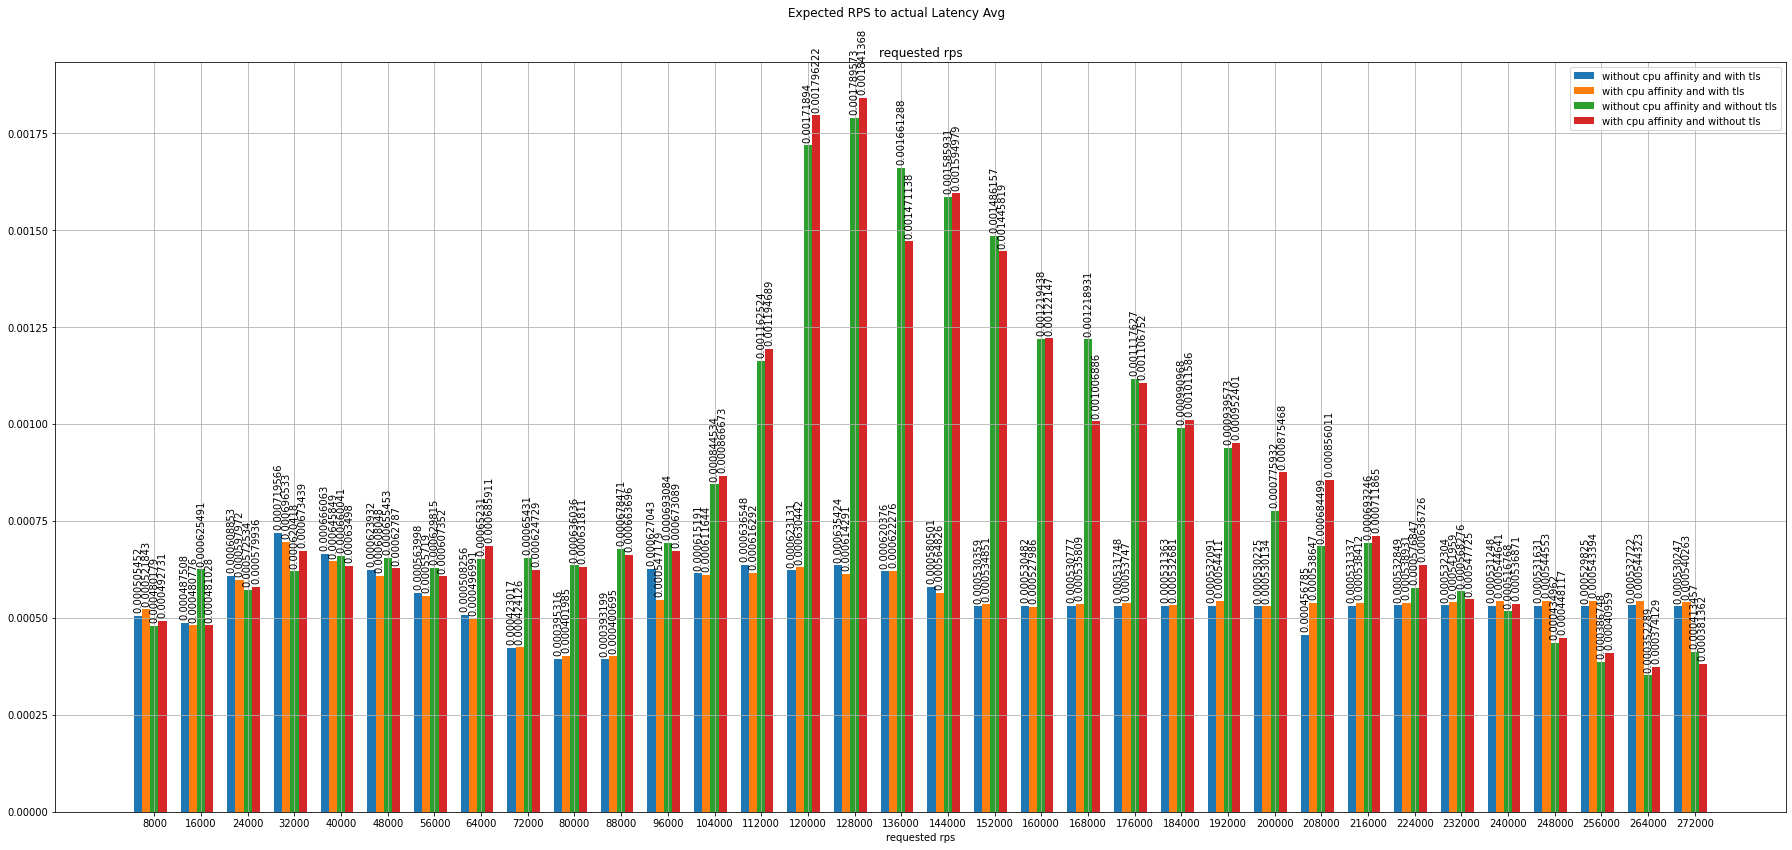

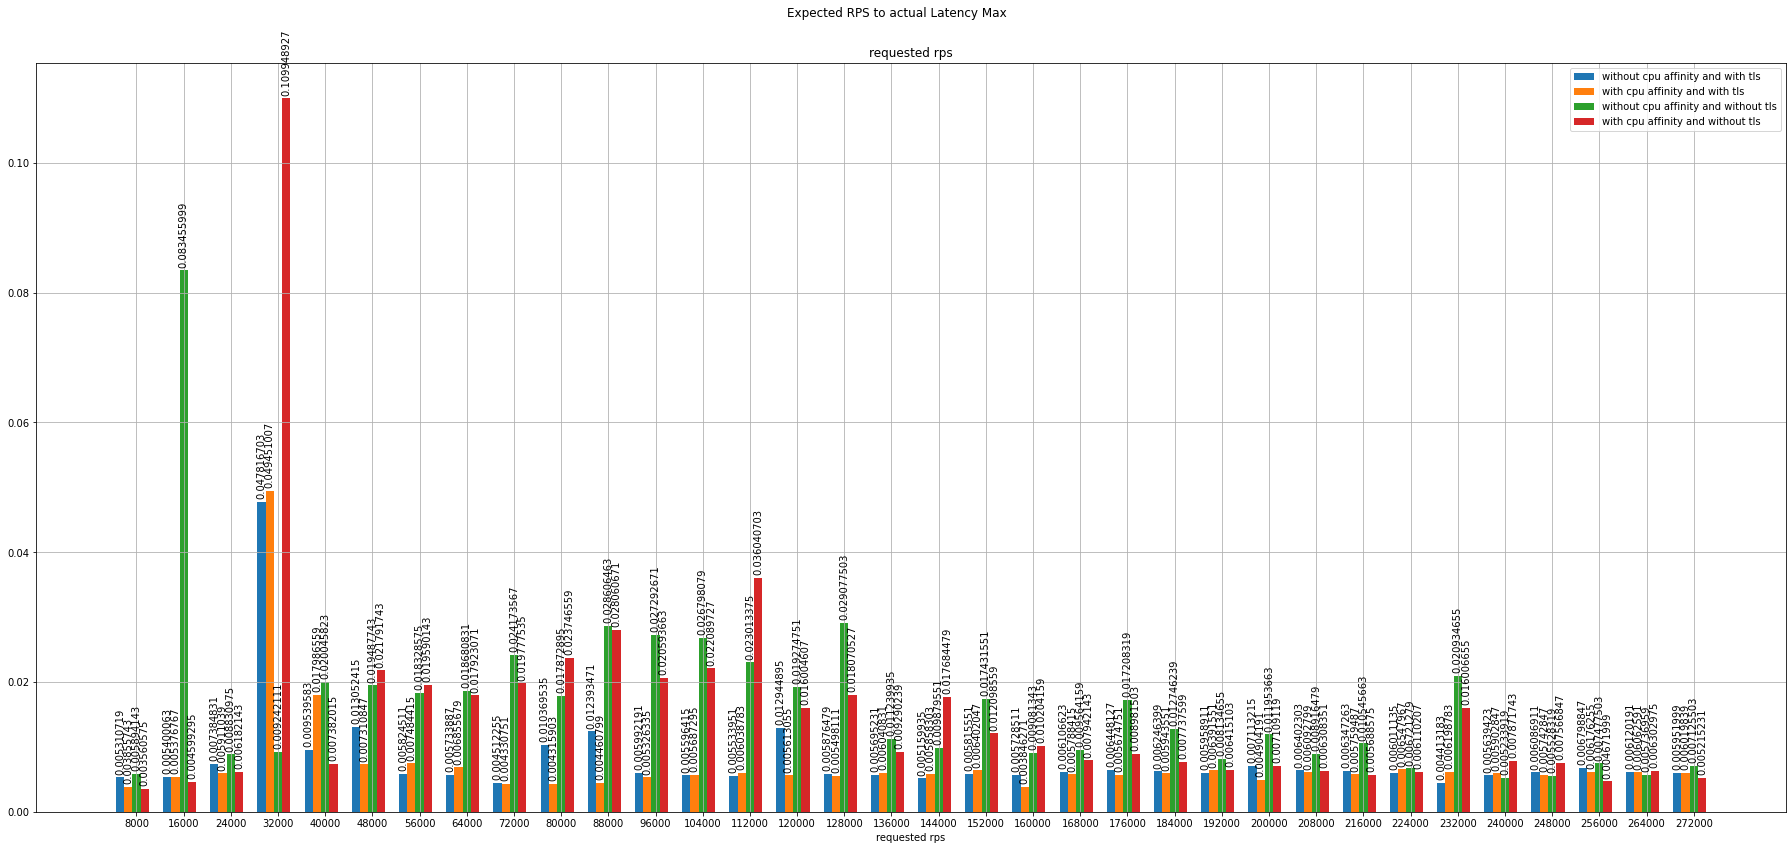

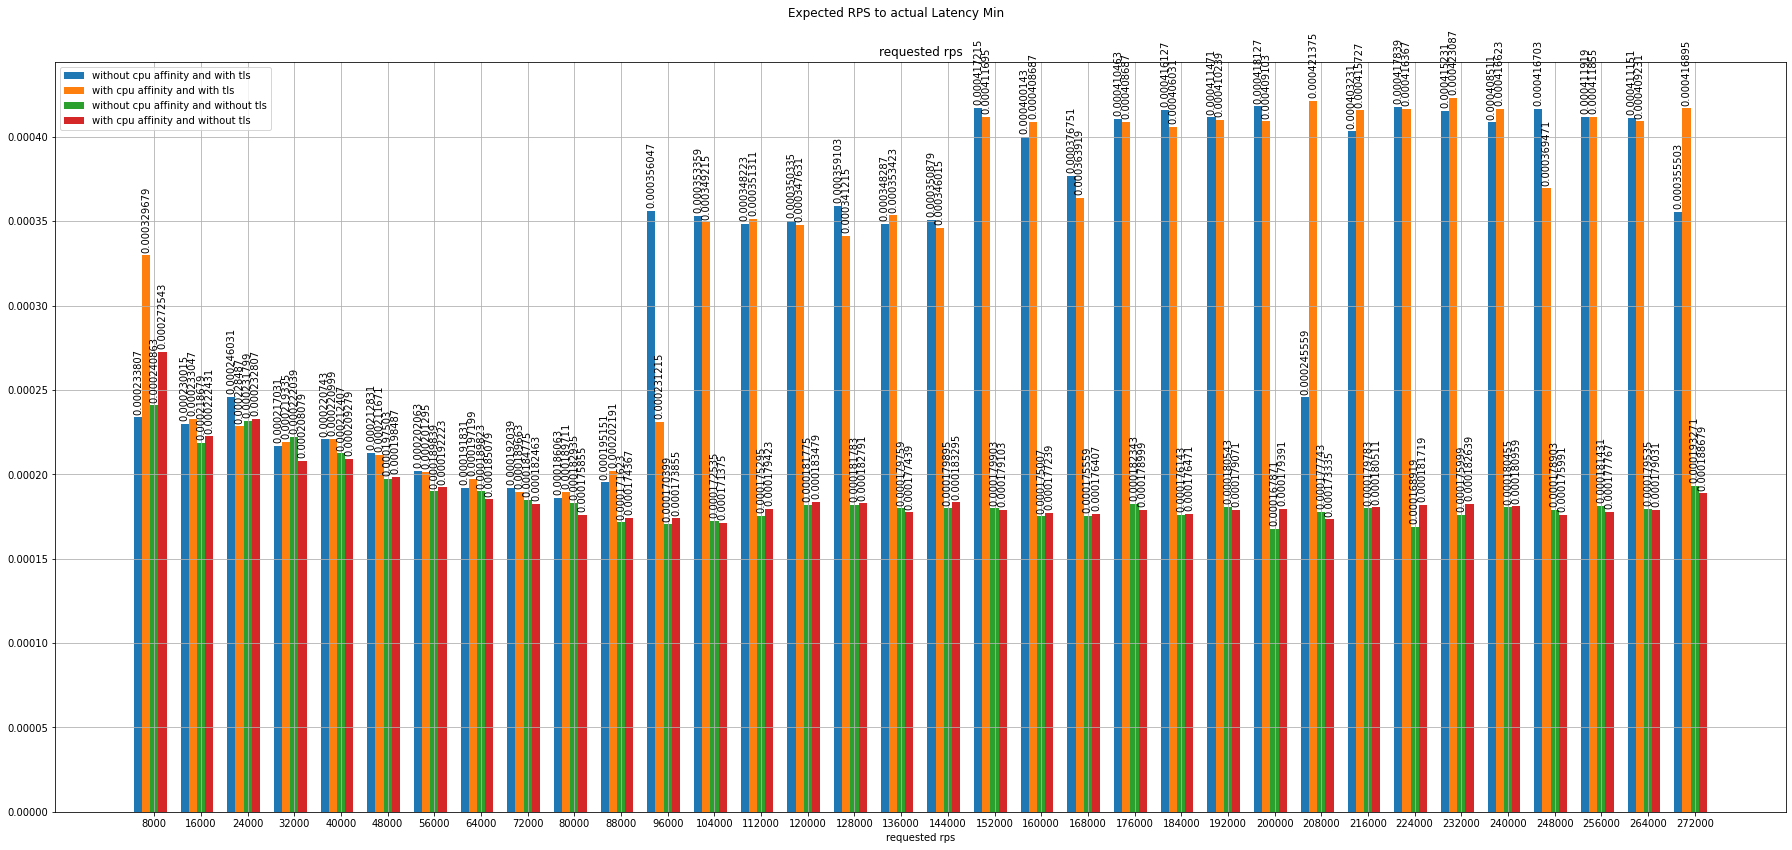

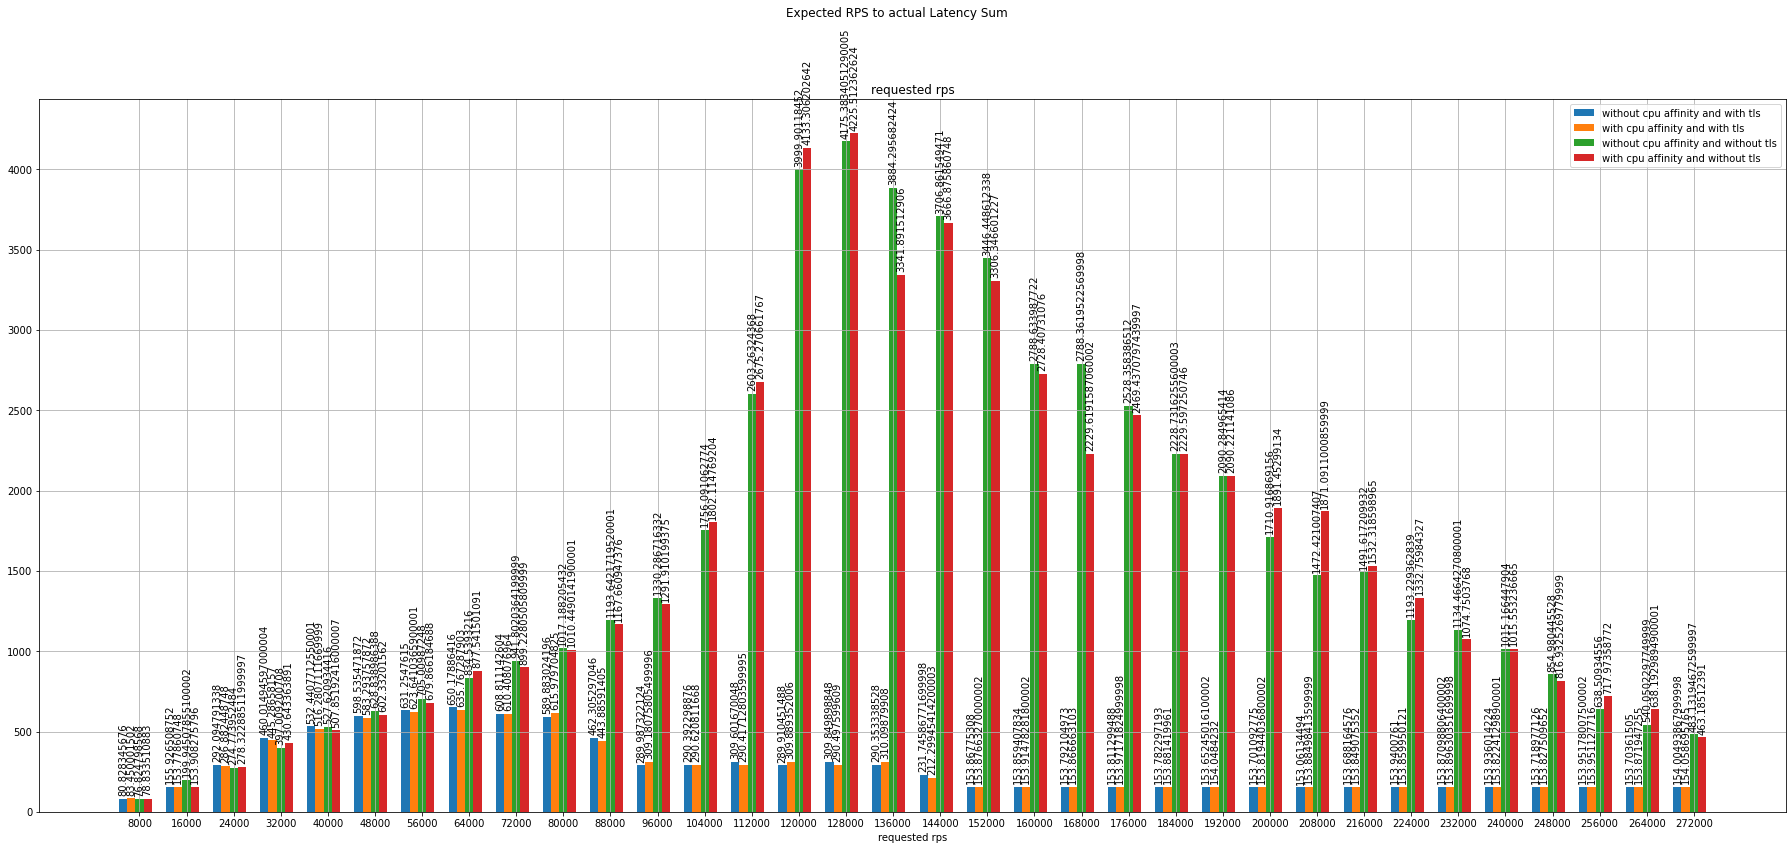

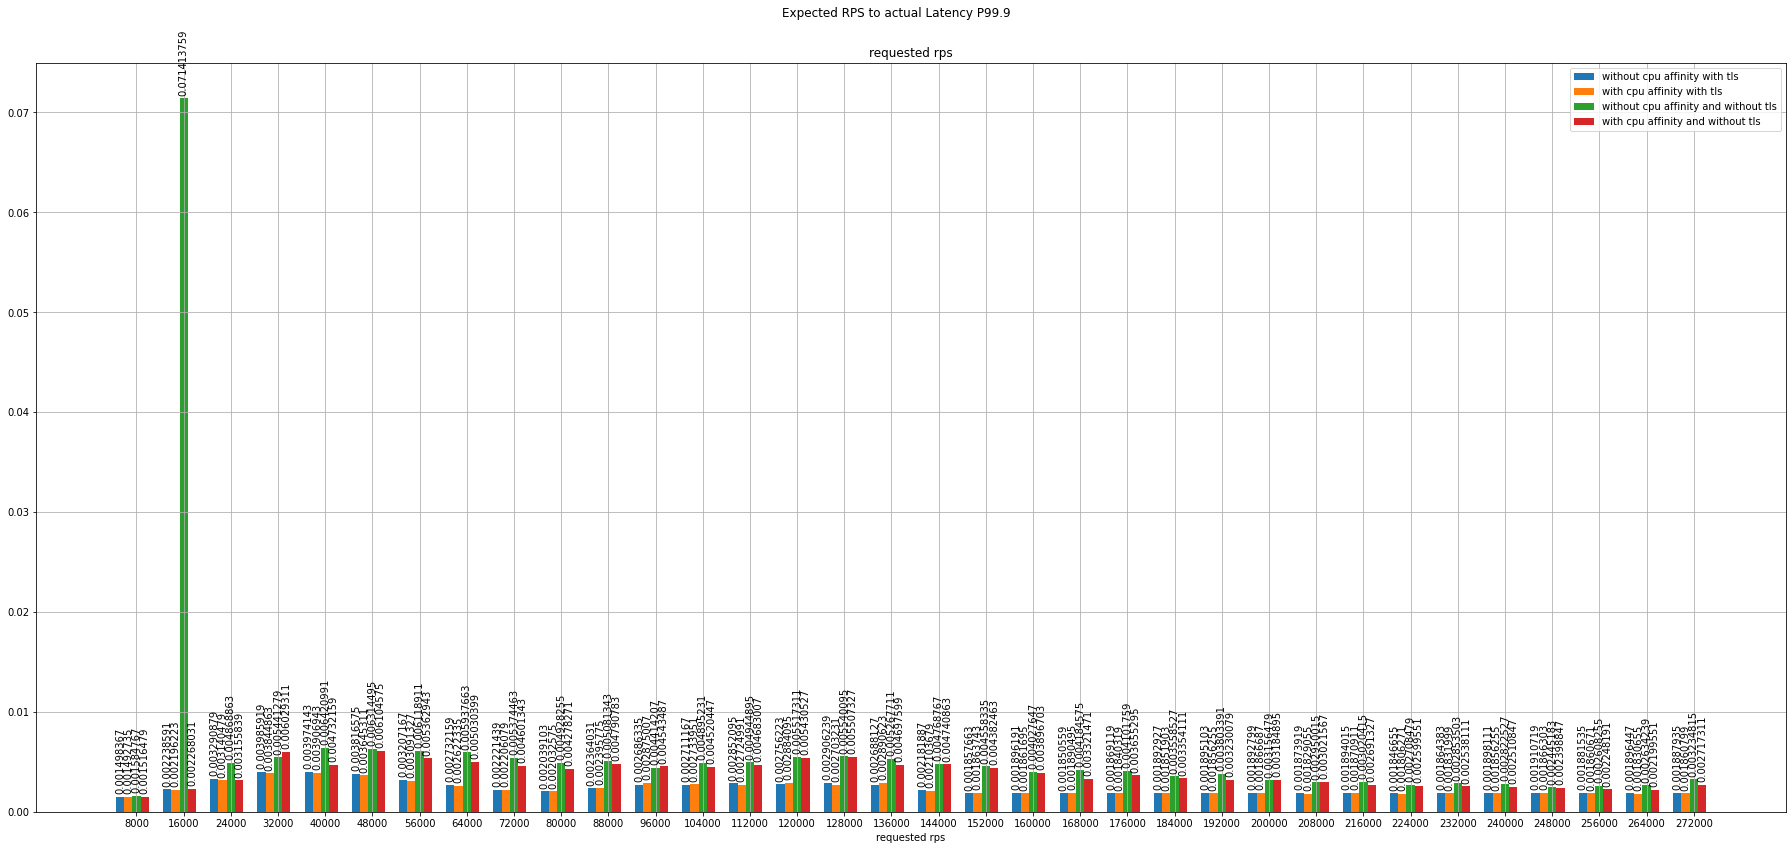

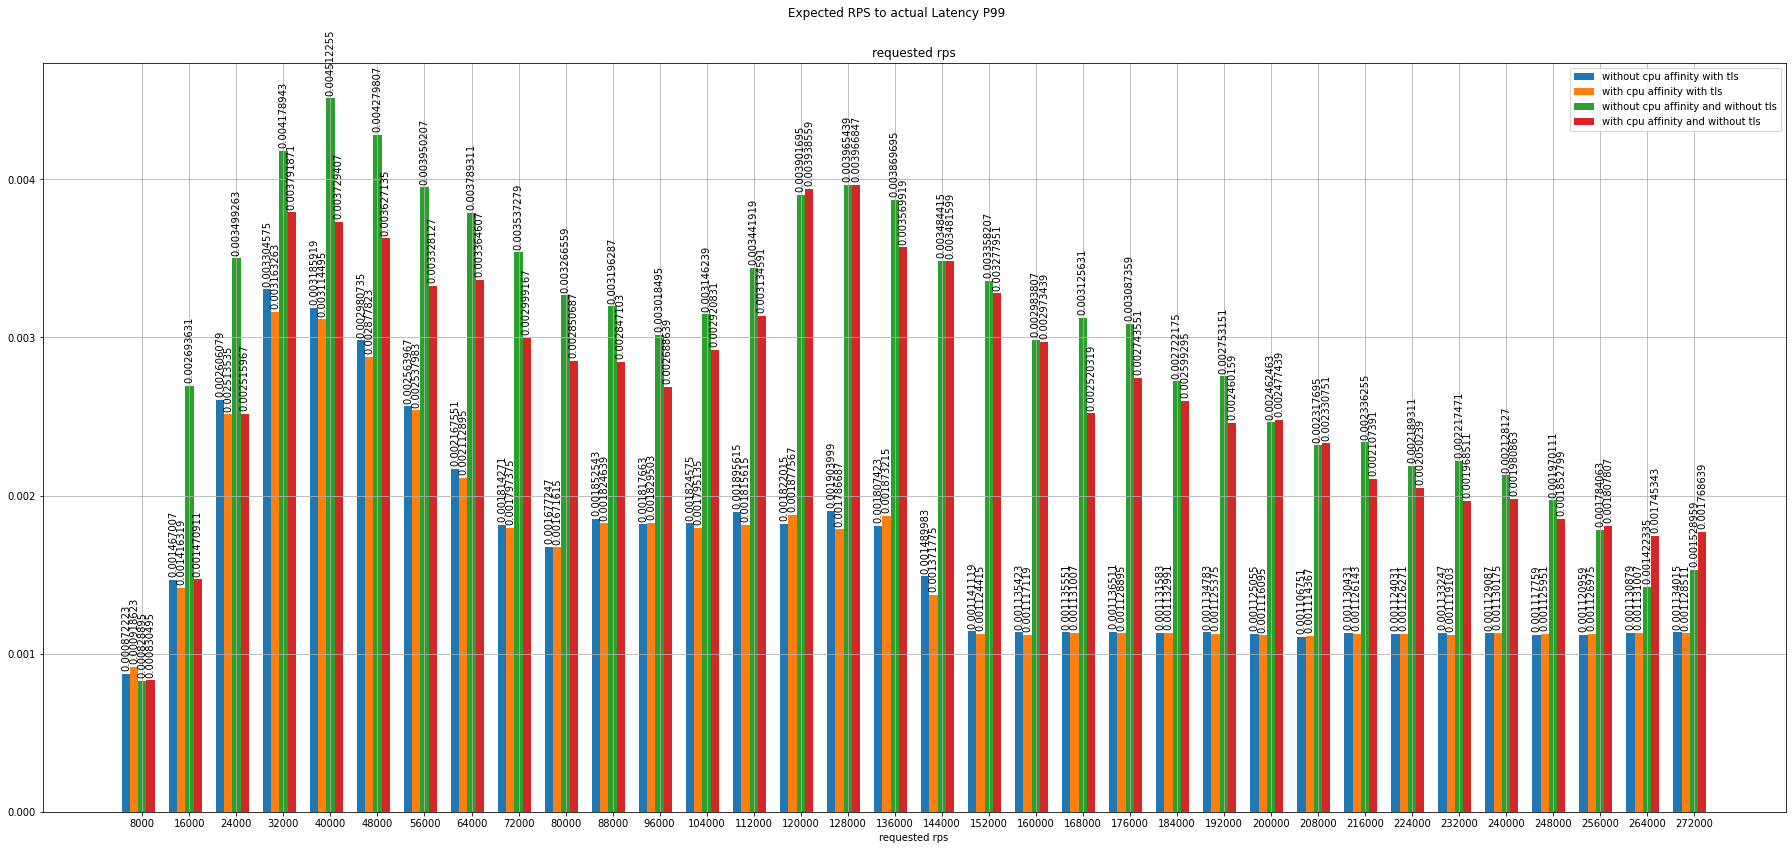

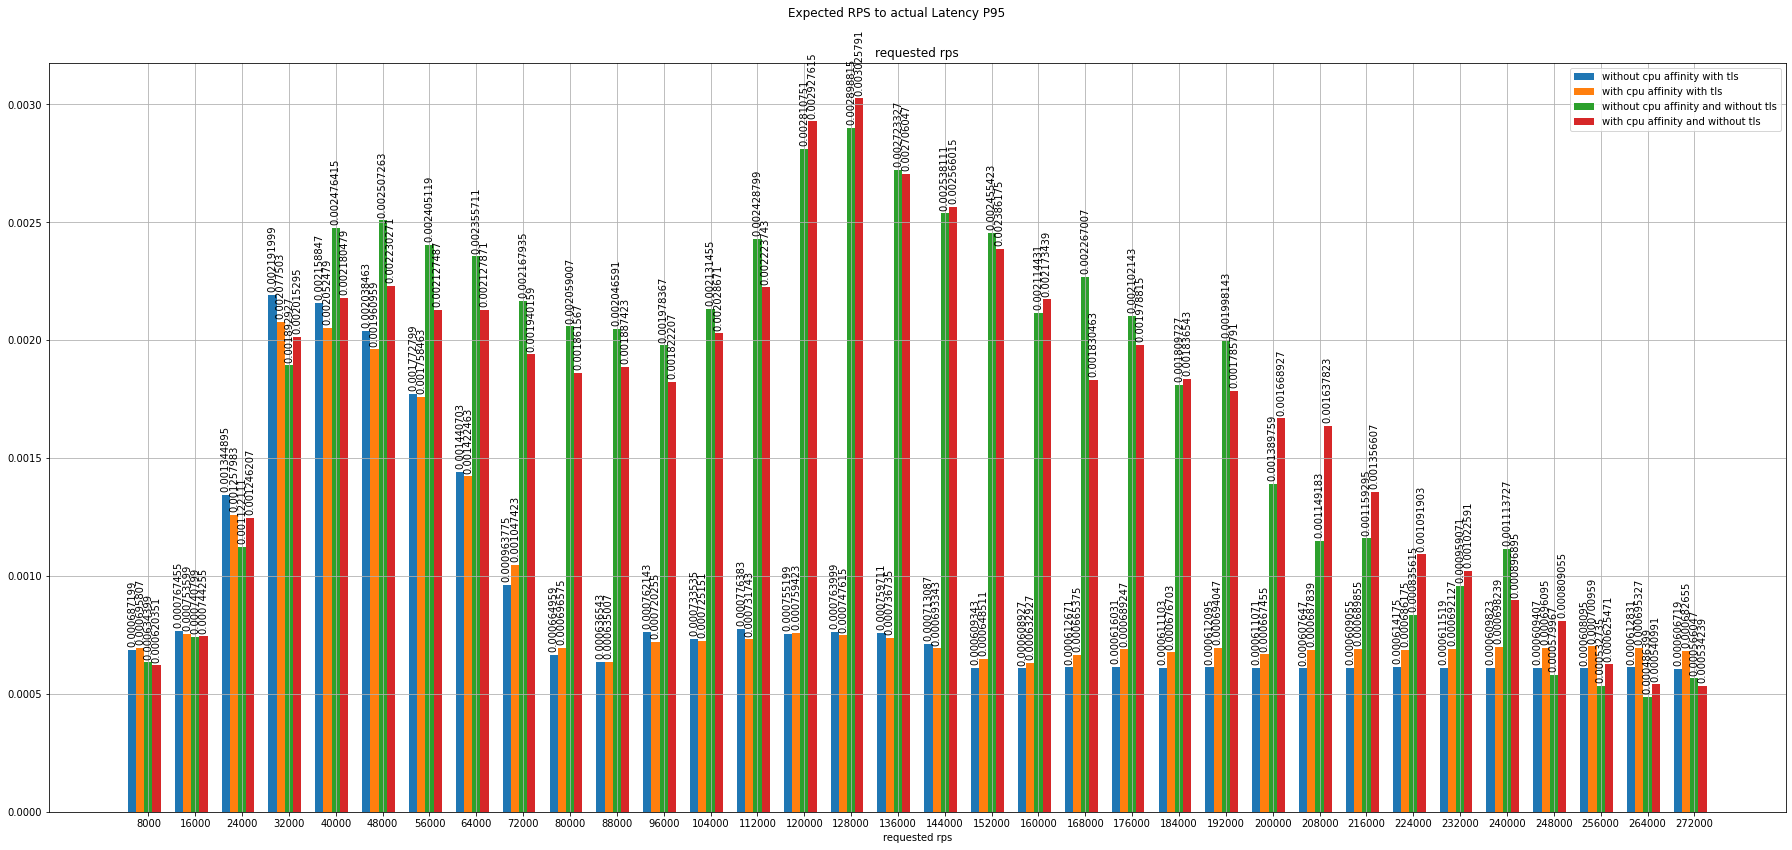

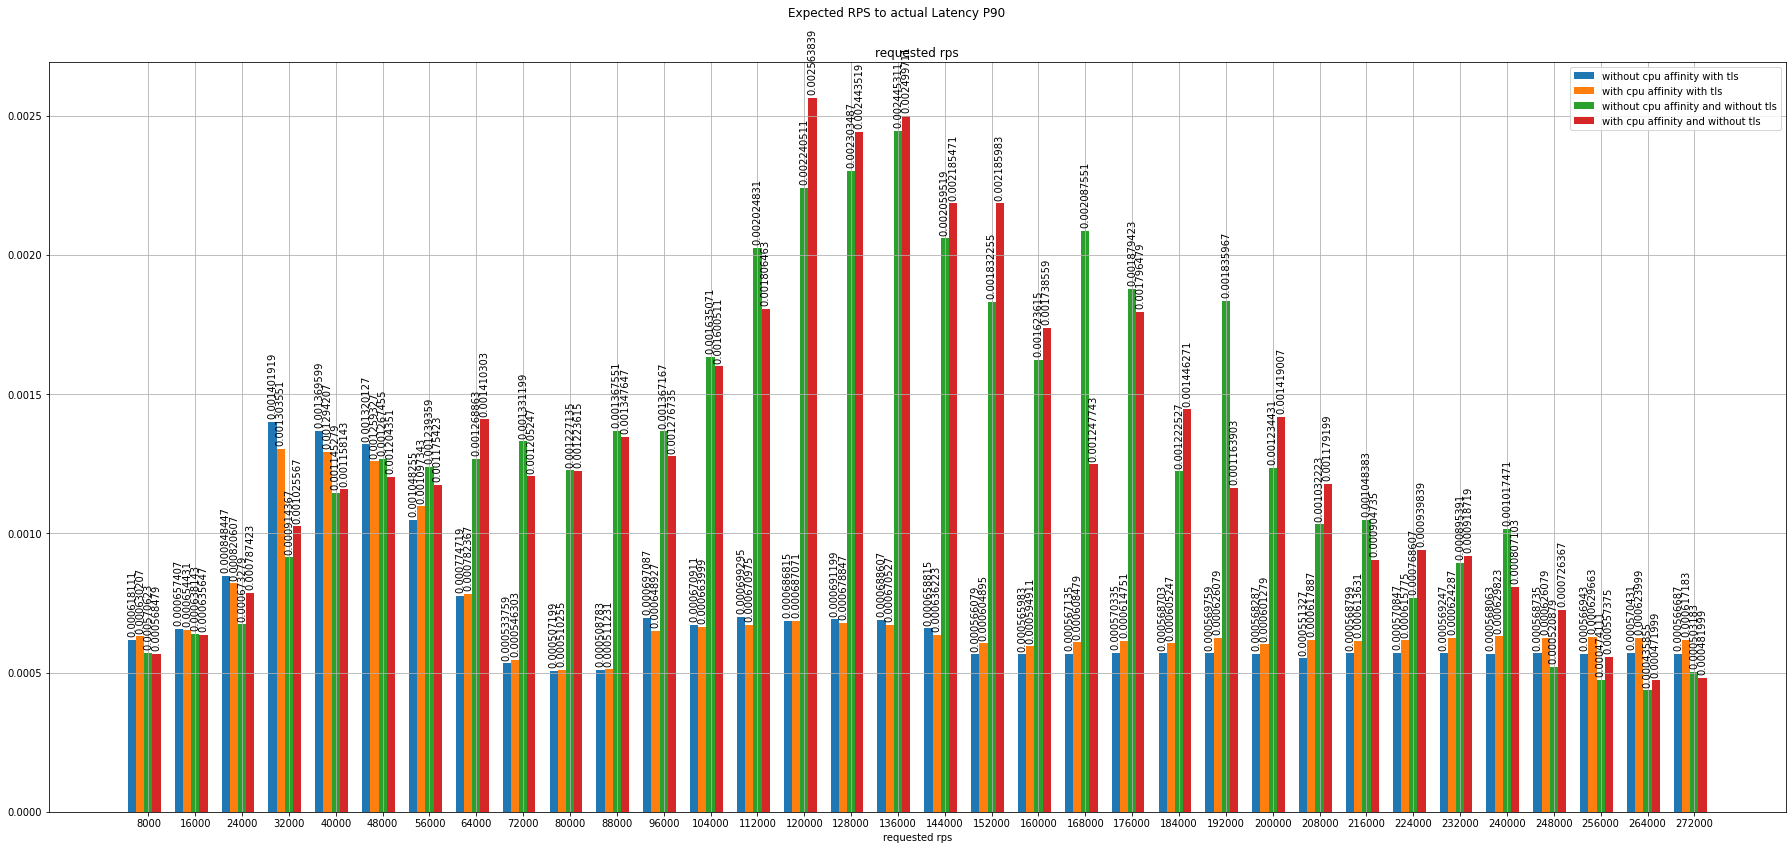

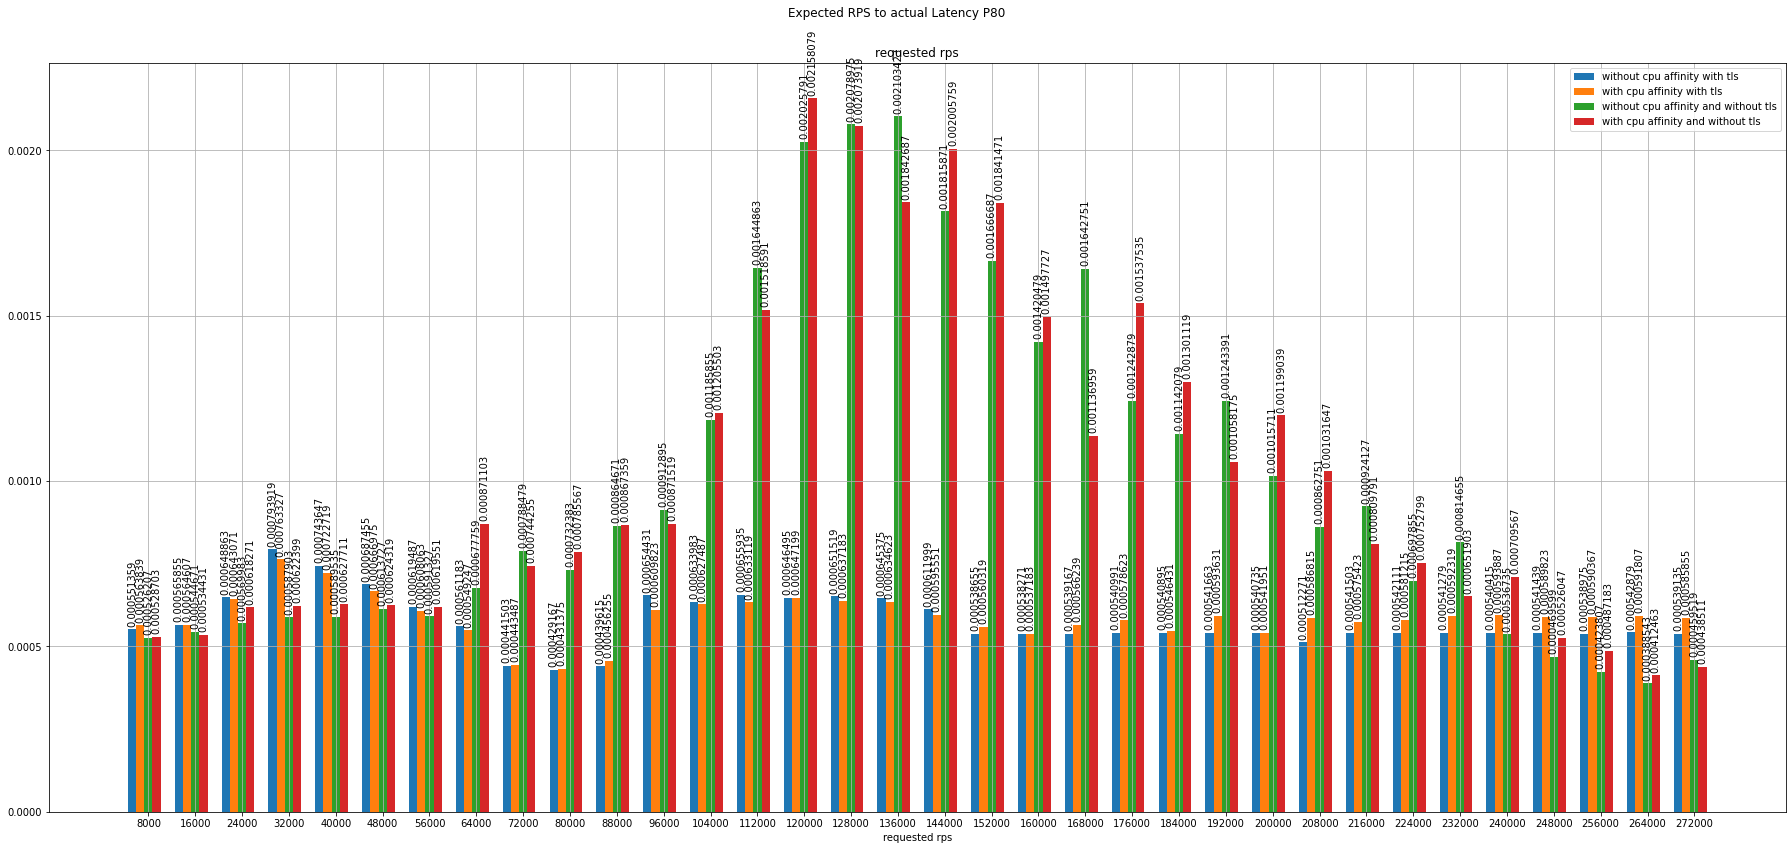

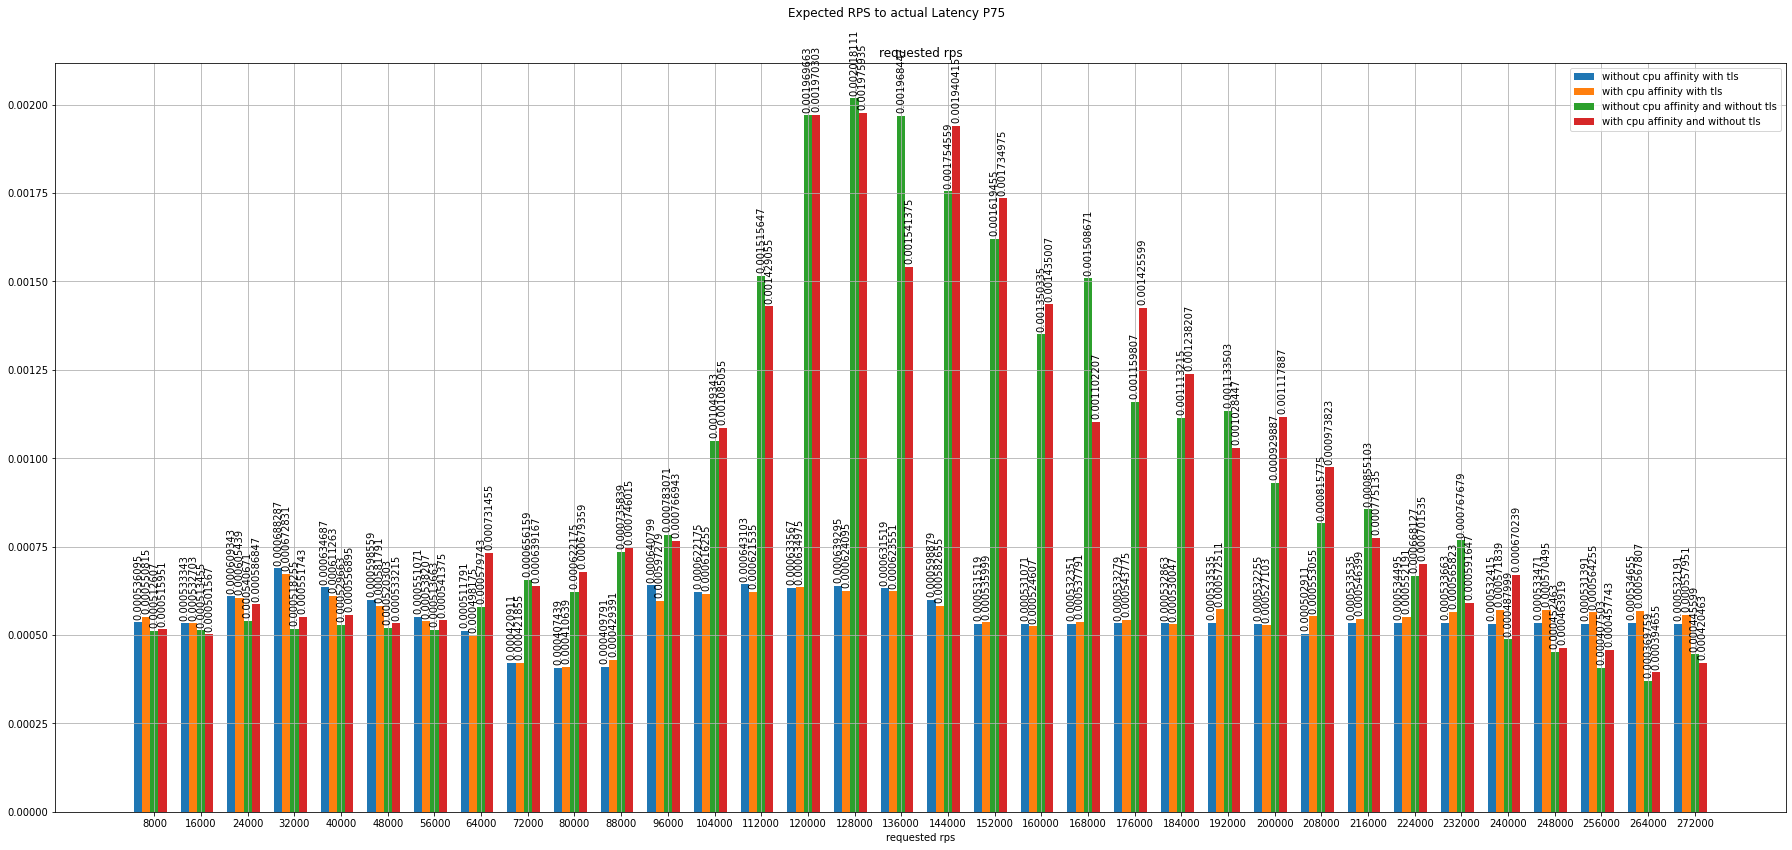

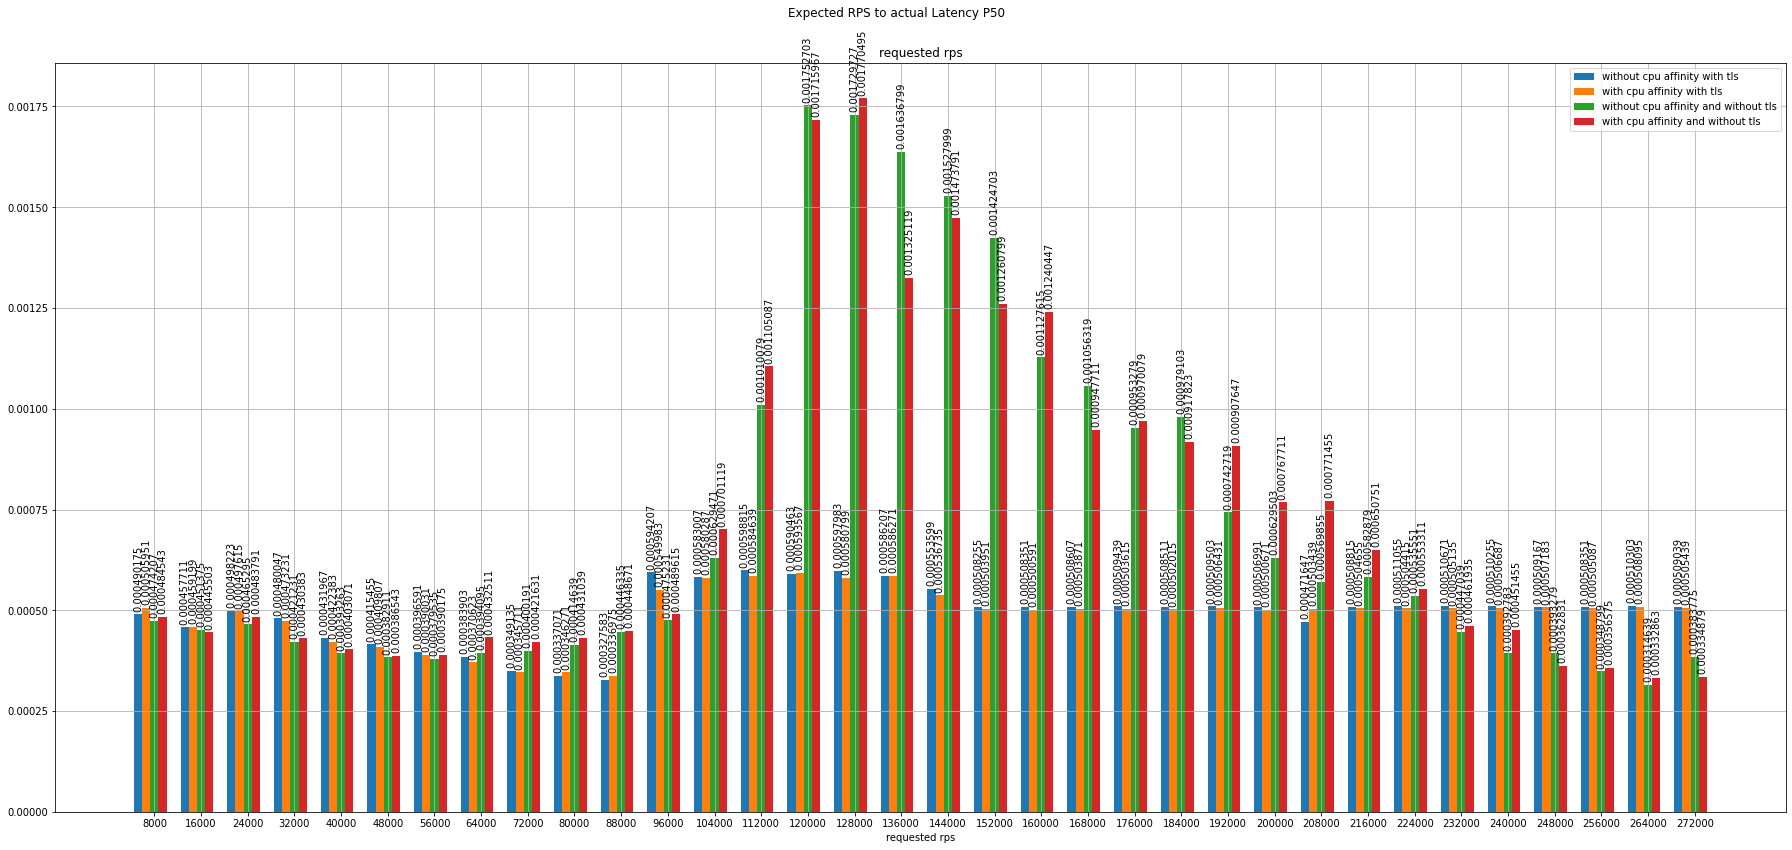

In [116]:
import matplotlib.pyplot as plt
import json
import numpy as np

"""
    This test is running with nighthawk-client as client tool sending request to Envoy, Envoy proxy
    the request to fortio server.

    fortio server running with a large set of cpu pinning to ensure the server has enough performance.
    nighthawk-client is running with 4 cpu pinning
    envoy is running with 5 cpu pinning, and 4 worker.
    
    two versions of envoy are tested, one is without cpu affinity, another is with cpu affiniy.
    
    The cpu affinity one will pinning the worker to separate cpu.
    
    test with: RPS_START=5000 RPS_INCREASE=5000 RPS_END=100000 BASE_DIR=envoy_without_cpuaffinity bash ./nighthawk-client.sh
"""

""" client with 4 cpus
base_dir = './result'
dur=120
cur=4
rps_start=5000
rps_end=35000
rps_increase=5000
"""

""" client with 8 cpus and short duration
base_dir = './result_8_client_cpus'
dur=20
cur=8
rps_start=5000
rps_end=35000
rps_increase=5000
"""

""" client with 8 cpus and more granular sample 
base_dir = './result_8_client_cpus_dur_120'
dur=120
cur=8
rps_start=1000
rps_end=10000
rps_increase=1000
"""

""" with request body and with isolated cpu thread
base_dir = './result_8_client_cpus_8_cur_bodysize_512'
dur=120
cur=8
rps_start=1000
rps_end=35000
rps_increase=1000
"""

""" for the no cpuaffinty case, the envoy and nighthawk will share same set cpu
base_dir = './result_8_client_cpus_8_cur_bodysize_512_with_noise'
dur=120
cur=8
rps_start=1000
rps_end=35000
rps_increase=1000
"""
"""
base_dir = './result_8_client_cpus_8_cur_bodysize_512_with_noise_8_core'
dur=120
cur=8
rps_start=1000
rps_end=35000
rps_increase=1000
"""

base_dir = './result_remote'
dur=20
cur=8
rps_start=1000
rps_end=35000
rps_increase=1000

envoy_with_cpu_affinity_with_tls = base_dir + '/envoy-with-cpu-affinity-with-tls'
envoy_without_cpu_affinity_with_tls = base_dir + '/envoy-without-cpu-affinity-with-tls'

envoy_with_cpu_affinity_without_tls = base_dir + '/envoy-with-cpu-affinity-without-tls'
envoy_without_cpu_affinity_without_tls = base_dir + '/envoy-without-cpu-affinity-without-tls'

percentiles_labels = ['P99.9', 'P99', 'P95', 'P90', 'P80', 'P75', 'P50']

def get_data(data_dir, latency_map, actual_rps_map):
    expected_rps_to_latency_map = latency_map
    expected_rps_to_actual_rps_map = actual_rps_map
    
    latency_map['Avg'] = {}
    latency_map['Max'] = {}
    latency_map['Min'] = {}
    latency_map['Sum'] = {}
    for label in percentiles_labels:
        expected_rps_to_latency_map[label] = {}
    
    for rps in range(rps_start, rps_end, rps_increase):
        file_name = "%(base_dir)s/nighthawk_rps_%(rps)s_connections_%(conn)s_concurrency_%(cur)s_duration_%(dur)s.json" % {
            "base_dir": data_dir,
            'rps': rps,
            "conn": 100,
            "cur": cur,
            "dur": dur,
        }
        f = open(file_name)
        json_data = json.load(f)

        expected_rps_to_actual_rps_map[json_data['RequestedQPS']] = json_data['ActualQPS']

        expected_rps_to_latency_map['Avg'][json_data['RequestedQPS']] = json_data['DurationHistogram']['Avg']
        expected_rps_to_latency_map['Max'][json_data['RequestedQPS']] = json_data['DurationHistogram']['Max']
        expected_rps_to_latency_map['Min'][json_data['RequestedQPS']] = json_data['DurationHistogram']['Min']
        expected_rps_to_latency_map['Sum'][json_data['RequestedQPS']] = json_data['DurationHistogram']['Sum']

        for per in json_data['DurationHistogram']['Percentiles']:
            if per['Percentile'] == 99.9:
                expected_rps_to_latency_map['P99.9'][json_data['RequestedQPS']] = per['Value']
            elif per['Percentile'] == 99:
                expected_rps_to_latency_map['P99'][json_data['RequestedQPS']] = per['Value']
            elif per['Percentile'] == 99:
                expected_rps_to_latency_map['P99'][json_data['RequestedQPS']] = per['Value']
            elif per['Percentile'] == 95:
                expected_rps_to_latency_map['P95'][json_data['RequestedQPS']] = per['Value']
            elif per['Percentile'] == 90:
                expected_rps_to_latency_map['P90'][json_data['RequestedQPS']] = per['Value']
            elif per['Percentile'] == 80:
                expected_rps_to_latency_map['P80'][json_data['RequestedQPS']] = per['Value']
            elif per['Percentile'] == 75:
                expected_rps_to_latency_map['P75'][json_data['RequestedQPS']] = per['Value']
            elif per['Percentile'] == 50:
                expected_rps_to_latency_map['P50'][json_data['RequestedQPS']] = per['Value']


# with cpu affinity, with tls
envoy_with_cpu_affinity_with_tls_latency_map = {}
envoy_with_cpu_affinity_with_tls_actual_rps_map = {}

get_data(envoy_with_cpu_affinity_with_tls, envoy_with_cpu_affinity_with_tls_latency_map, envoy_with_cpu_affinity_with_tls_actual_rps_map)

# without coup affinity, with tls
envoy_without_cpu_affinity_with_tls_latency_map = {}
envoy_without_cpu_affinity_with_tls_actual_rps_map = {}

get_data(envoy_without_cpu_affinity_with_tls, envoy_without_cpu_affinity_with_tls_latency_map, envoy_without_cpu_affinity_with_tls_actual_rps_map)

# with cpu affinity, without tls
envoy_with_cpu_affinity_without_tls_latency_map = {}
envoy_with_cpu_affinity_without_tls_actual_rps_map = {}

get_data(envoy_with_cpu_affinity_without_tls, envoy_with_cpu_affinity_without_tls_latency_map, envoy_with_cpu_affinity_without_tls_actual_rps_map)

# without cpu affinity, without tls
envoy_without_cpu_affinity_without_tls_latency_map = {}
envoy_without_cpu_affinity_without_tls_actual_rps_map = {}

get_data(envoy_without_cpu_affinity_without_tls, envoy_without_cpu_affinity_without_tls_latency_map, envoy_without_cpu_affinity_without_tls_actual_rps_map)


everything = [
    {
        "title": 'Expected RPS to actual RPS',
        "axs": [
            {
                'label': 'without cpu affinity and with tls',
                'map': envoy_without_cpu_affinity_with_tls_actual_rps_map
            },
            {
                'label': 'with cpu affinity and with tls',
                'map': envoy_with_cpu_affinity_with_tls_actual_rps_map
            },
            {
                'label': 'without cpu affinity and without tls',
                'map': envoy_without_cpu_affinity_without_tls_actual_rps_map
            },
            {
                'label': 'with cpu affinity and without tls',
                'map': envoy_with_cpu_affinity_without_tls_actual_rps_map
            },
        ]
    },
    {
        "title": 'Expected RPS to actual Latency Avg',
        "axs": [
            {
                'label': 'without cpu affinity and with tls',
                'map': envoy_without_cpu_affinity_with_tls_latency_map['Avg']
            },
            {
                'label': 'with cpu affinity and with tls',
                'map': envoy_with_cpu_affinity_with_tls_latency_map['Avg']
            },
            {
                'label': 'without cpu affinity and without tls',
                'map': envoy_without_cpu_affinity_without_tls_latency_map['Avg']
            },
            {
                'label': 'with cpu affinity and without tls',
                'map': envoy_with_cpu_affinity_without_tls_latency_map['Avg']
            }
        ]
    },
    {
        "title": 'Expected RPS to actual Latency Max',
        "axs": [
            {
                'label': 'without cpu affinity and with tls',
                'map': envoy_without_cpu_affinity_with_tls_latency_map['Max']
            },
            {
                'label': 'with cpu affinity and with tls',
                'map': envoy_with_cpu_affinity_with_tls_latency_map['Max']
            },
            {
                'label': 'without cpu affinity and without tls',
                'map': envoy_without_cpu_affinity_without_tls_latency_map['Max']
            },
            {
                'label': 'with cpu affinity and without tls',
                'map': envoy_with_cpu_affinity_without_tls_latency_map['Max']
            }
        ]
    },
    {
        "title": 'Expected RPS to actual Latency Min',
        "axs": [
            {
                'label': 'without cpu affinity and with tls',
                'map': envoy_without_cpu_affinity_with_tls_latency_map['Min']
            },
            {
                'label': 'with cpu affinity and with tls',
                'map': envoy_with_cpu_affinity_with_tls_latency_map['Min']
            },
            {
                'label': 'without cpu affinity and without tls',
                'map': envoy_without_cpu_affinity_without_tls_latency_map['Min']
            },
            {
                'label': 'with cpu affinity and without tls',
                'map': envoy_with_cpu_affinity_without_tls_latency_map['Min']
            }
        ]
    },
    {
        "title": 'Expected RPS to actual Latency Sum',
        "axs": [
            {
                'label': 'without cpu affinity and with tls',
                'map': envoy_without_cpu_affinity_with_tls_latency_map['Sum']
            },
            {
                'label': 'with cpu affinity and with tls',
                'map': envoy_with_cpu_affinity_with_tls_latency_map['Sum']
            },
            {
                'label': 'without cpu affinity and without tls',
                'map': envoy_without_cpu_affinity_without_tls_latency_map['Sum']
            },
            {
                'label': 'with cpu affinity and without tls',
                'map': envoy_with_cpu_affinity_without_tls_latency_map['Sum']
            }
        ]
    },
]

for label in percentiles_labels:
    everything.append(
        {
        "title": 'Expected RPS to actual Latency %s' % label,
        "axs": [
            {
                'label': 'without cpu affinity with tls',
                'map': envoy_without_cpu_affinity_with_tls_latency_map[label]
            },
            {
                'label': 'with cpu affinity with tls',
                'map': envoy_with_cpu_affinity_with_tls_latency_map[label]
            },
            {
                'label': 'without cpu affinity and without tls',
                'map': envoy_without_cpu_affinity_without_tls_latency_map[label]
            },
            {
                'label': 'with cpu affinity and without tls',
                'map': envoy_with_cpu_affinity_without_tls_latency_map[label]
            }
        ]
    }
    )

def generate_plots(everything_):
    for data_maps in everything_:
        fig, axs = plt.subplots(figsize=(25, 8), sharey=True)
        fig.suptitle(data_maps['title'])
        for axs_data in data_maps['axs']:
            axs.plot(list(axs_data['map'].keys()), list(axs_data['map'].values()), label=axs_data['label'])
        axs.grid(True)
        axs.legend()
        axs.set_xlabel('requested rps')

                 
generate_plots(everything)


def generate_bars(everything_):
    width = 0.35/2
    for data_maps in everything_:
        fig, axs = plt.subplots(figsize=(25, 12), sharey=True)
        fig.suptitle(data_maps['title'])
        x = np.arange(len(data_maps['axs'][0]['map'].keys()))

        rect1 = axs.bar(x - width * 2, list(data_maps['axs'][0]['map'].values()), width, label=data_maps['axs'][0]['label'])
        rect2 = axs.bar(x - width, list(data_maps['axs'][1]['map'].values()), width, label=data_maps['axs'][1]['label'])
        rect3 = axs.bar(x, list(data_maps['axs'][2]['map'].values()), width, label=data_maps['axs'][2]['label'])
        rect4 = axs.bar(x + width, list(data_maps['axs'][3]['map'].values()), width, label=data_maps['axs'][3]['label'])

        axs.set_title('requested rps')
        axs.set_xticks(x)
        axs.set_xticklabels(["%d" % key for key in data_maps['axs'][0]['map'].keys()])
        
        axs.grid(True)
        axs.set_xlabel('requested rps')
        axs.legend()

        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                axs.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', rotation='vertical')

        autolabel(rect1)
        autolabel(rect2)
        autolabel(rect3)
        autolabel(rect4)

        fig.tight_layout()
        plt.show()

generate_bars(everything)

[0 1 2 3 4]
[-0.175  0.825  1.825  2.825  3.825]


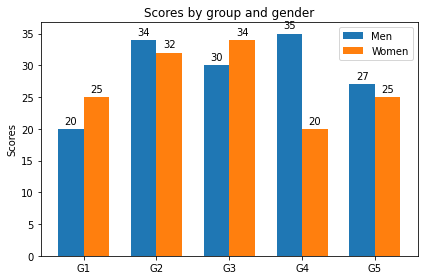

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
print(x)
fig, ax = plt.subplots()
print(x - width/2)
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()